<center><img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;"></center>

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import numpy as np
import pandas as pd
from getpass import getpass

In [2]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 75

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False

In [3]:
%%capture
user = getpass()
password = getpass()
host = getpass()
conx_string = f'postgresql://{user}:{password}@{host}/project_sql'

%sql $conx_string

<center><b>ER Diagram</b><br>
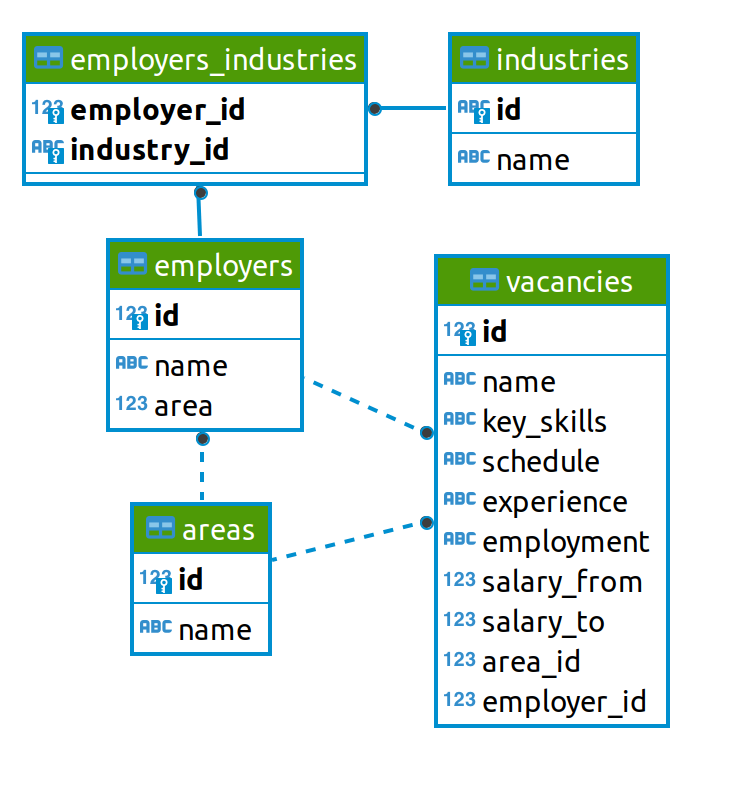

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [4]:
%%capture
%%sql query_3_1 <<

select count(*) as num_of_vacancies 
from vacancies

In [5]:
query_3_1

,num_of_vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [6]:
%%capture
%%sql query_3_2 <<

select count(*) as num_of_employers 
from employers

In [7]:
query_3_2

,num_of_employers
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [8]:
%%capture
%%sql query_3_3 <<

select count(*) as num_of_regions 
from areas

In [9]:
query_3_3

,num_of_regions
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [10]:
%%capture
%%sql query_3_4 <<

select count(*) as num_of_industries 
from industries

In [11]:
query_3_4

,num_of_industries
0,294


***

In [12]:
%%capture
%%sql unit3_1 <<

select 
    a.idx,
    a.areas,
    e.employers
from (
    (select 'Total' as idx, count(*) as "areas" from areas as a
    union
    select 'in vacancies table' as idx, count(distinct v.area_id) as "areas" from vacancies as v
    union
    select 'not in vacancies table' as idx, count(*) as "areas" from areas as a left join vacancies as v on a.id = v.area_id where v.area_id is null
    ) as a
join 
    (select 'Total' as idx, count(*) as "employers" from employers as e
    union
    select 'in vacancies table' as idx, count(distinct v.employer_id) as "employers" from vacancies as v
    union
    select 'not in vacancies table' as idx, count(*) as "employers" from employers as e left join vacancies as v on e.id = v.employer_id where v.employer_id is null
    ) as e
on a.idx = e.idx
)
order by e.employers desc

In [13]:
%%capture
%%sql unit3_2 <<

select
	areas.area,
	areas.vacancies,
	areas.pct_cum,
	employers.employer,
	employers.vacancies,
	employers.pct_cum,
	industries.industry,
	industries.vacancies,
	industries.pct_cum
from
	(select 
		row_number() over (order by vacancies desc) as row_num,
		area,
		vacancies,
		round(sum(vacancies) over (order by vacancies desc) / sum(vacancies) over () * 100, 2) as pct_cum
	from (
		select 
			a.id,
			a."name" as area,
			count(v.id) as vacancies
		from vacancies as v
		join areas as a 
			on v.area_id = a.id
		group by 1, 2
	) as q
	limit 10
	) as areas
join (
	select 
		row_number() over (order by vacancies desc) as row_num,
		employer,
		vacancies,
		round(sum(vacancies) over (order by vacancies desc) / sum(vacancies) over () * 100, 2) as pct_cum
	from (
		select 
			e.id,
			e."name" as employer,
			count(v.id) as vacancies
		from vacancies as v
		join employers as e 
			on v.employer_id = e.id
		group by 1, 2
	) as q
	limit 10
) as employers
	on areas.row_num = employers.row_num
join (
	select 
	row_number() over (order by vacancies desc) as row_num,
	industry,
	vacancies,
	round(sum(vacancies) over (order by vacancies desc) / sum(vacancies) over () * 100, 2) as pct_cum
	from (
		select
			industry,
			count(id) as vacancies
		from (
			select 
				v.id,
				replace(i.id, '.', '')::int,
				coalesce(i."name", 'Не указано') as industry,
				row_number() over (partition by v.id order by replace(i.id, '.', '')::int) as ind_num
			from vacancies as v
			join employers as e 
				on v.employer_id = e.id
			left join employers_industries as ei 
				on e.id = ei.employer_id
			left join industries as i 
				on ei.industry_id = i.id
		) as q1
		where ind_num = 1
		group by 1
	) q2
	limit 10
) as industries
	on areas.row_num = industries.row_num

In [14]:
unit3_1

,idx,areas,employers
0,Total,1362,23501
1,in vacancies table,769,14906
2,not in vacancies table,593,8595


In [15]:
unit3_2

,area,vacancies,pct_cum,employer,vacancies,pct_cum,industry,vacancies,pct_cum
0,Москва,5333,10.84,Яндекс,1933,3.93,"Системная интеграция, автоматизации технологических и бизнес-процессов...",10676,21.70
1,Санкт-Петербург,2851,16.64,Ростелеком,491,4.93,Не указано,10084,42.20
2,Минск,2112,20.93,Тинькофф,444,5.83,Разработка программного обеспечения,5646,53.67
3,Новосибирск,2006,25.01,СБЕР,428,6.70,"Интернет-компания (поисковики, платежные системы, соц.сети, информацион...",3504,60.80
4,Алматы,1892,28.85,Газпром нефть,331,7.37,Банк,1960,64.78
5,Екатеринбург,1698,32.30,ИК СИБИНТЕК,327,8.04,Интернет-провайдер,1095,67.01
6,Нижний Новгород,1670,35.70,МТС,292,8.63,Кадровые агентства,866,68.77
7,Казань,1415,38.57,DataArt,247,9.13,Мобильная связь,702,70.19
8,Краснодар,1301,41.22,Совкомбанк Технологии,204,9.55,"Нефтепереработка, нефтехимия (производство)",454,71.12
9,Самара,1144,43.54,Первый Бит,176,9.91,"Промышленное, бытовое электрооборудование и электротехника (производство)",426,71.98


*Выводы по предварительному анализу данных*   
База данных вакансий Headhunter состоит из пяти таблиц, главной из которых является vacancies, которая в настоящее время содержит 49 197 вакансий. Внешними ключами в таблице являются идентификаторы региона и работодателя, находящиеся в таблицах areas и employers, соответственно. В справочнике регионов содержатся сведения о 1 362 регионах, из которых 769 (56%) встречаются в перечне вакансий. В справочнике работодателей содержится информация о 23 501 работодателе, из которых 14 906 (63%) разместили вакансии. Так как каждый из работодателей имеет возможность указать одну или несколько релевантных сфер деятельности, в базе данных присутствует промежуточная таблица employers_industries, которая позволяет организовать связь типа многие-ко-многим между работодателями и сферами деятельности (справочник их классификации содержит 294 записей в таблице industries). Так как заполнение данной информации является для работодателя добровольным, для части из них эта информация не указана и, таким образом, не всегда может быть использована для классификации вакансий.

В таблице выше представлен топ вакансий в разрезе каждого из основных категориальных признаков: регионов, работодателей и сфер деятельности. Так, географически, большинство вакансий размещено, как очевидно, для Москвы и Санкт-Петербурга. На два города приходится почти 17% доступных вакансий. Помимо городов России в базе так же присутствуют города стран ближнего зарубежья. В целом на десять регионов приходится чуть менее половины всех вакансий, что говорит о крайне высокой концентрации по географии.

Среди работодателей лидерство по количеству вакансий принадлежит Яндексу, который разместил почти каждую 26 вакансию. В перечне топ работодалей по числу размещенных вакансий присутствуют представители банковской сферы (3 ед.), телекома (2 ед.), системной интеграции (2 ед.) и один разработчик ПО. На каждого из работадателей в топ списке, помимо Яндекса, приходится от половины до процента всех вакансий.

Список сфер деятельности, в которых в основном открыты вакансии, довольно близко повторяет структуру российской экономики. После сфер, относимых напрямую к ИТ -- системная интеграция, разработка ПО, интернет-компании и телеком -- следуют нефтедобыча, нефтепереработка и нефтехимия, производство машин и оборудования. Наличие деятельности кадровых агентств в перечне свидетельствует, что часть вакансий публикуется не напрямую работадателями, а через рекрутинговые агентства (около двух процентов). Для 20% вакансий сфера деятельности не указана, так как работодатель не предоставил соответствующую информацию.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [16]:
%%capture
%%sql query_4_1 <<

select 
    a."name" as area_name,
    count(*) as cnt
from vacancies as v
join areas as a 
    on v.area_id = a.id
group by a."name"
order by count(*) desc

In [17]:
query_4_1.head()

,area_name,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [18]:
%%capture
%%sql query_4_2 <<

select count(*) as cnt
from vacancies
where 
    salary_from is not null 
    or salary_to is not null

In [19]:
query_4_2

,cnt
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [20]:
%%capture
%%sql query_4_3 <<

select 
    avg(salary_from)::int as avr_salary_from,
    avg(salary_to)::int as avr_salary_to
from 
    vacancies

In [21]:
query_4_3

,avr_salary_from,avr_salary_to
0,71065,110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [22]:
%%capture
%%sql query_4_4 <<

select 
    schedule, 
    employment, 
    count(*) as cnt
from vacancies
group by 
    schedule, 
    employment
order by count(*) desc

In [23]:
query_4_4.head()

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [24]:
%%capture
%%sql query_4_5 <<

select 
    experience, 
    count(*) as cnt
from vacancies
group by experience
order by count(*)

In [25]:
query_4_5

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

In [26]:
%%capture
%%sql unit_4_1 <<

select
    case 
        when a.name = 'Москва' then 'Москва'
        when a.name = 'Санкт-Петербург' then 'Санкт-Петербург'
        when a.name in ('Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 
            'Уфа', 'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Пермь', 'Волгоград') then 'Города-миллионники'
        else 'Прочие города'
    end as city_type,
    v.experience,
    percentile_cont(0.5) within group(order by salary_from)::int as salary_from,
    percentile_cont(0.5) within group(order by salary_to)::int as salary_to
from vacancies as v
join areas as a on v.area_id = a.id
group by
    case 
        when a.name = 'Москва' then 'Москва'
        when a.name = 'Санкт-Петербург' then 'Санкт-Петербург'
        when a.name in ('Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 
            'Уфа', 'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Пермь', 'Волгоград') then 'Города-миллионники'
        else 'Прочие города' 
    end,
    v.experience

In [27]:
rpl_dict = {
    'Москва': '1. Москва',
    'Санкт-Петербург': '2. Санкт-Петербург',
    'Города-миллионники': '3. Города-миллионники',
    'Прочие города': '4. Прочие города',
    'Нет опыта': '1. Нет опыта',
    'От 1 года до 3 лет': '2. От 1 года до 3 лет',
    'От 3 до 6 лет': '3. От 3 до 6 лет',
    'Более 6 лет': '4. Более 6 лет'
    }
unit_4_1 = unit_4_1.replace(to_replace=rpl_dict)
unit_4_1 = pd.pivot(unit_4_1, index='city_type', columns='experience', values=['salary_from', 'salary_to'])
unit_4_1 = unit_4_1.rename(index={v:k for k, v in rpl_dict.items()})
unit_4_1 = unit_4_1.rename(columns={v:k for k, v in rpl_dict.items()}, level=1)
unit_4_1

salary_from                                               \
experience           Нет опыта От 1 года до 3 лет От 3 до 6 лет Более 6 лет   
city_type                                                                     
Москва                   50000              80000        150000      200000   
Санкт-Петербург          40000              70000        120000      120000   
Города-миллионники       30000              55000        100000      110000   
Прочие города            27200              47000         80000      116897   

                   salary_to                                               
experience         Нет опыта От 1 года до 3 лет От 3 до 6 лет Более 6 лет  
city_type                                                                  
Москва                 65000             120000        200000      250000  
Санкт-Петербург        51750              95000        160000      170000  
Города-миллионники     50000              80000        150000      150000  
Прочие города          46500              63000        137931      183070

*Выводы по детальному анализу вакансий*  
Из перечня вакансий, содержащихся в базе данных, 49 процентов содержат информацию о зарплатных ожиданиях работодателя (наличие минимальной, максимальной или обоих границ заработной платы). Для каждой из вакансий предусмотрено указание типа занятости (полная, частичная, проектная или стажировка), графика работы (полный день, удаленная работа, сменный/гибкий график или вахта), а так же требуемого опыта (всего четыре уровня).

В представленных вакансиях преимущественно требуются сотрудники, имеющие опыт работы до трех лет (68 процентов) на постоянную работу на территории работодателя (72 процента). Набирающий популярность формат удаленный работы встречается в 19% вакансий. Спрос на более опытных сотрудников со стажем работы более шести лет наблюдается всего в трех процентах вакансий. Предположительно, база вакансий содержит в большей части массовые вакансии в сфере информационных технологий.

Медианные зарплатные ожидания работадателей в разрезе регионов и требуемого опыта работы для ИТ-специальностей показывают схожую динамику с другими отраслями: в Москве уровень зарплат значительно выше, чем в любой другой локации (от 30% для начальных должностей до 75% для опытных специалистов). В Санкт-Петербурге уровень заработной платы находится между средними значениями Москвы и регионов.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [28]:
%%capture
%%sql query_5_1 <<

select
    emp_name
from (
    select 
        emp_name, 
        cnt, 
        rank() over (order by cnt desc) as rnk
    from (
        select 
            e."name" as emp_name,
            count(*) as cnt
        from vacancies as v
        join employers as e 
            on e.id = v.employer_id
        group by e."name"
    ) as q1
) as q2
where rnk in (1, 5)

In [29]:
query_5_1

,emp_name
0,Яндекс
1,Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [30]:
%%capture
%%sql query_5_2 <<

select 
    vac.area_name, 
    vac.vac_cnt, 
    emp.emp_cnt
from (
    select 
        a."name" as area_name,
        count(distinct v.id) as vac_cnt
    from areas as a
    left join vacancies as v
        on v.area_id = a.id
    group by a."name"
) as vac
join (
    select
        a."name" as area_name,
        count(distinct e.id) as emp_cnt
    from areas as a
    left join employers as e
        on e.area = a.id
    group by a."name"
) as emp
    on vac.area_name = emp.area_name
where vac_cnt = 0
order by emp_cnt desc
limit 1

In [31]:
query_5_2

,area_name,vac_cnt,emp_cnt
0,Россия,0,410


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [32]:
%%capture
%%sql query_5_3 <<

select 
    e.id, 
    e."name" as emp_name, 
    count(distinct v.area_id) as cnt
from employers as e
left join vacancies as v 
    on v.employer_id = e.id
group by 
    e.id, 
    e."name"
order by count(distinct v.area_id) desc

In [33]:
query_5_3.head(10)

,id,emp_name,cnt
0,1740,Яндекс,181
1,2748,Ростелеком,152
2,5724811,Спецремонт,116
3,5130287,Поляков Денис Иванович,88
4,3682876,ООО ЕФИН,71
5,7944,Совкомбанк,63
6,3776,МТС,55
7,53797,"ЭФКО, Управляющая компания",49
8,3776815,КРОН,48
9,4352,Почта России,48


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [34]:
%%capture
%%sql query_5_4 <<

select count(*) as cnt
from employers as e
left join employers_industries as ei 
    on e.id = ei.employer_id
where ei.employer_id is null

In [35]:
query_5_4

,cnt
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [36]:
%%capture
%%sql query_5_5 <<

select 
    emp_name
from (
    select 
        emp_name, 
        row_number() over(order by emp_name) as row_num
    from (
        select 
            e.id, 
            e."name" as emp_name,
            count(*) as cnt
        from employers as e
        join employers_industries as ei 
            on e.id = ei.employer_id
        group by 
            e.id, 
            e."name"
        having count(*) = 4
    ) as q1
) as q2
where row_num = 3

In [37]:
query_5_5

,emp_name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [38]:
%%capture
%%sql query_5_6 <<

select count(*) as cnt
from employers as e
join employers_industries as ei 
    on e.id = ei.employer_id
join industries as i
    on ei.industry_id = i.id
where i.name = 'Разработка программного обеспечения'

In [39]:
query_5_6

,cnt
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [40]:
dfs = pd.read_html('https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8')
cities = dfs[1].loc[:, 'Город'].replace(to_replace=r'\[.\]', value='', regex=True)
cities = tuple(cities)

In [41]:
%%capture
%%sql query_5_7 <<

select
	coalesce(a."name", 'Total')  as area_name,
	count(*) as cnt
from vacancies as v
join areas as a
	on v.area_id = a.id
where 
 	v.employer_id = (select id from employers where "name" = 'Яндекс')
 	and a."name" in :cities
group by 
	grouping sets ((a.name), ())
order by count(*)

In [42]:
query_5_7

,area_name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Самара,26
8,Уфа,26
9,Краснодар,30


***

In [43]:
%%capture
%%sql unit4_1 <<

with top_emp as (
	select 
		row_num,
		id,
		employer,
		vacancies
	from (
		select 
			row_number() over (order by vacancies desc) as row_num,
			id,
			employer,
			vacancies
		from (
			select 
				e.id,
				e."name" as employer,
				count(v.id) as vacancies
			from vacancies as v
			join employers as e 
				on v.employer_id = e.id
			group by 1, 2
		) as q1
	) as q2
	where row_num <=10
)
select
	round(avg(vac_cnt), 1) as vac_per_emp
from (
	select
		v.employer_id,
		count(v.id) as vac_cnt
	from vacancies as v
	where v.employer_id not in (select id from top_emp)
	group by v.employer_id
) as q

In [44]:
%%capture
%%sql unit4_2 <<

select
    industries,
    ind_cnt,
    round(ind_cnt / sum(ind_cnt) over (), 2) as ind_pct
from (
    select
        industries,
        count(*) as ind_cnt
    from (
        select 
            e.id,
            count(ei.industry_id) as industries
        from employers as e
        left join employers_industries as ei on e.id = ei.employer_id
        group by
            e.id,
            e.name
    ) as q1
    group by industries
) as q2
order by industries

In [45]:
%%capture
%%sql unit4_3 <<

with salaries as (
    select
        e.name as emp_name,
        v.salary_from as salary,
        ntile(5) over (partition by e.name order by v.salary_from) as quintile
    from vacancies as v
    join employers as e 
        on v.employer_id = e.id
    where 
        e.name in ('Яндекс', 'Ростелеком', 'Тензор', 'Первый Бит', 'МТС')
        and v.salary_from is not null
)
select 
    p20.emp_name,
    round(p20.p20_salary::numeric, -2) as p20_salary,
    round(p80.p80_salary::numeric, -2) as p80_salary
from (
        (select 
            emp_name,
            avg(salary)::int as p20_salary
        from salaries
        where quintile = 1
        group by emp_name) as p20
    join
        (select 
            emp_name,
            avg(salary)::int as p80_salary
        from salaries
        where quintile = 5
        group by emp_name) as p80
    on p20.emp_name = p80.emp_name
)
order by p20.p20_salary

In [46]:
unit4_1

,vac_per_emp
0,3.0


In [47]:
unit4_2

,industries,ind_cnt,ind_pct
0,0,8419,0.36
1,1,6452,0.27
2,2,3639,0.15
3,3,2607,0.11
4,4,1138,0.05
5,5,1246,0.05


In [48]:
unit4_3

,emp_name,p20_salary,p80_salary
0,Яндекс,13600,37700
1,Ростелеком,25000,83300
2,Первый Бит,26000,153400
3,МТС,34400,110700
4,Тензор,36100,293400


*Выводы по анализу работодателей*  
Имеющаяся база данных вакансий содержит информацию, опубликованную 23 501 работодателем. Исключив из выборки информацию о топ 10 работодателях по количеству размещенных вакансий, на каждого работодателя в среднем приходится по три вакансии. Как видно из результатов запроса 5.2 некоторые крупные национальные компании указывают в качестве места расположения страну, а вакансии публикуют в разрезе отдельных городов. Аналогичная ситуация наблюдается для региональных компаний (указывается субъект Российской Федерации).

Так как заполнение сферы деятельности является опциональным, довольно большое количество работодателей не указывают род своей деятельности (36%). В 42% случаях работодатели указывают основной либо основной и вспомогательный вид деятельности (в частности, промышленные предприятия: основной -- производство, вспомогательный -- дистрибуция/торговля).

Для работодателей, которые указывают зарплатные ожидания в вакансиях, возможно рассчитать средние уровни предлагаемой заработной платы для должностей начального и старшего уровня. В качестве начального уровня принимаются вакансии, входящие в первый квинтиль данных по заработной плате (все ЗП ниже и включая 20 перцентиль); в качестве старшего уровня, входящие в пятый квинтиль (все ЗП больше и включая 80 перцентиль). Так как в текущей выборке больше вакансий с заполненными данными по нижней границе, в расчете для примера используется именно она. Из таблицы выше, например, видно, что публикуемые Яндексом вакансии, в которых указаны зарплатные ожидания, явно относятся к должностям с неполной занятостью на самых начальных уровнях карьеры. Для остальных работодателей уровни заработных плат, скорее всего, преимущественно относятся к должностям с полным рабочим днем. Опираясь на подобные данные можно судить об относительных уровнях оплаты труда для низко- и высокооплачиваемых должностях в различных компаниях.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [49]:
%%capture
%%sql query_6_1 <<

select count(*) as cnt
from vacancies
where 
	"name" ilike '%data%' 
	or "name" ilike '%данн%'

In [50]:
query_6_1

,cnt
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [51]:
%%capture
%%sql query_6_2 <<

select count(*) as num_of_ds_vac
from vacancies
where 
	("name" ilike '%data scientist%'
	or "name" ilike '%data science%'
	or "name" ilike '%исследователь данных%'
	or ("name" like '%ML%' and "name" not like '%HTML%')
	or "name" ilike '%machine learning%'
	or "name" ilike '%машинн%обучен%')
	and ("name" ilike '%junior%'
		or experience = 'Нет опыта'
		or employment = 'Стажировка')

In [52]:
query_6_2

,num_of_ds_vac
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

In [53]:
%%capture
%%sql query_6_3 <<

select count(*) as num_of_ds_vac
from vacancies
where
	("name" ilike '%data scientist%'
	or "name" ilike '%data science%'
	or "name" ilike '%исследователь данных%'
	or ("name" like '%ML%' and "name" not like '%HTML%')
	or "name" ilike '%machine learning%'
	or "name" ilike '%машинн%обучен%')
	and (key_skills ilike '%sql%'
		or key_skills ilike '%postgres%')

In [54]:
query_6_3

,num_of_ds_vac
0,201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

In [55]:
%%capture
%%sql query_6_4 <<

select count(*) as num_of_ds_vac
from vacancies
where
	("name" ilike '%data scientist%'
	or "name" ilike '%data science%'
	or "name" ilike '%исследователь данных%'
	or ("name" like '%ML%' and "name" not like '%HTML%')
	or "name" ilike '%machine learning%'
	or "name" ilike '%машинн%обучен%')
	and key_skills ilike '%python%'

In [56]:
query_6_4

,num_of_ds_vac
0,351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [57]:
%%capture
%%sql query_6_5 <<

select round(avg(length(key_skills) - length(replace(key_skills, chr(9), '')) + 1), 2) as avr_key_skills
from vacancies
where
	("name" ilike '%data scientist%'
	or "name" ilike '%data science%'
	or "name" ilike '%исследователь данных%'
	or ("name" like '%ML%' and "name" not like '%HTML%')
	or "name" ilike '%machine learning%'
	or "name" ilike '%машинн%обучен%')

In [58]:
query_6_5

,avr_key_skills
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [59]:
%%capture
%%sql query_6_6 <<

select
	experience,
	avg(salary)::int as avg_salary
from (
	select 
		experience,
		case 
			when salary_from is null then salary_to
			when salary_to is null then salary_from
			else (salary_to + salary_from)/2
		end as salary
	from vacancies
	where
		("name" ilike '%data scientist%'
		or "name" ilike '%data science%'
		or "name" ilike '%исследователь данных%'
		or ("name" like '%ML%' and "name" not like '%HTML%')
		or "name" ilike '%machine learning%'
		or "name" ilike '%машинн%обучен%')
		and (salary_from is not null 
	    	or salary_to is not null)
) as q
group by experience

In [60]:
query_6_6

,experience,avg_salary
0,Нет опыта,74643
1,От 1 года до 3 лет,139675
2,От 3 до 6 лет,243115


***

In [61]:
%%capture
%%sql unit_6_1 <<

select 
	skills,
	cnt,
	pct_cum
from (
	select
		skills,
		cnt,
		round(sum(cnt) over (order by cnt desc) / sum(cnt) over () * 100, 1) as pct_cum
	from (
		select
			skills,
			count(*) cnt
		from (
			select regexp_split_to_table(key_skills, chr(9)) as skills
			from vacancies
			where
				("name" ilike '%data scientist%'
				or "name" ilike '%data science%'
				or "name" ilike '%исследователь данных%'
				or ("name" like '%ML%' and "name" not like '%HTML%')
				or "name" ilike '%machine learning%'
				or "name" ilike '%машинн%обучен%')
		) as q1
		group by skills
	) as q2
) as q3
where pct_cum <= 2/3.*100
order by cnt desc

In [62]:
unit_6_1['skills'].to_numpy()

array(['Python', 'SQL', 'Machine Learning', 'Git', 'Математическая статистика', 'Data Analysis',
       'Pandas', 'Data Science', 'ML', 'Английский язык', 'Linux', 'Анализ данных', 'PyTorch',
       'Big Data', 'Математическое моделирование', 'Статистический анализ', 'NLP', 'C++', 'Spark',
       'Tensorflow', 'Numpy', 'Hadoop', 'Машинное обучение', 'Docker', 'Математический анализ',
       'Java', 'Аналитическое мышление', 'Deep Learning', 'MS PowerPoint', 'ООП', 'Data Mining',
       'Computer Vision', 'machine learning', 'sklearn', 'PostgreSQL', 'SCALA'], dtype=object)

*Выводы по предметному анализу*  
Из всей базы данных только около четырех процентов вакансий связано с работой с данными и около одного процента с дата сайенс. В качестве основных навыков, которые требуются работодателям, выделяется общее знание работы с Python и SQL запросами. Кроме того, в число наиболее популярных навыков входят:
* библиотеки Python для работы с данными (Pandas, PyTorch, Spark, Tenserflow, Numpy, sklearn);
* теоретические знания статистики и математического моделирования;
* вспомогательное ПО (Git, Docker, MS PowerPoint);
* другие языки программирования (C++, Java, Scala);
* СУБД PostgreSQL и фреймворк для работы с большими данными Hadoop;
* знание английского языка.

# Общий вывод по проекту

Текущая база содержит вакансии для поиска сотрудников в сфере информационных технологий в компании, напрямую связанные с разработкой и развитием ИТ и в которых поддержание ИТ инфраструктуры является вспомогательной функцией. Большая часть вакансий доступна в крупных городах России, где сконцентрировано большинство ИТ компаний и промышленных предприятий. За исключением самых крупных работодателей, которые публикуют по несколько сотен вакансий по всем регионам, в среднем на каждого работодателя приходится по три вакансии. Не смотря на распространение формата удаленной работы, большинство вакансий тем не менее подразумевают нахождением сотрудников на территории работодателя полный рабочий день. Среди вакансий присутствует -- в основном за счет Яндекса -- большое количество вакансий, связанных с поддержкой клиентов ИТ сервисов. Для данных вакансий, не имеющих прямого отношения к разработке, как зарплатные ожидания работодателей, так и форматы и условия работы отличаются от среднеотраслевых показателей (более низкая заработная плата, гибкий график/удаленный формат). Вне зависимости от направления дальнейшего использования данных, перечень подобных вакансий, вероятно, должен быть учтен особым образом.

Для построения модели машинного обучения по подбору специалистов в отрасли data science с учетом имеющихся данных необходимо провести дополнительную работу по классификации вакансий. В частности, помимо определения ключевых навыков, относящихся к интересующей специальности, скорее всего, потребуется парсинг атрибута названия вакансии для идентификации слов и их ранжирования по релевантности. Совместно, данные из этих двух атрибутов могут быть использованы для более точной выдачи в поиске и предложениях (на основе соответствия ключевым словам в резюме или запросах соискателей). Кроме того, так как около половины данных в целом не содержит зарплатных ожиданий, для более точного таргетинга вакансий возможно имеет смысл организация градация вакансий на основе содержащейся в них информации по прогнозной заработной плате.